In [1]:
import math
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
import matplotlib
import time
import scanpy as sc
import sklearn
import networkx as nx
import ot
import paste as pst
from paste.helper import to_dense_array
import anndata

In [ ]:
def normalize_layers(adatas, sample_groups, hv_genes=False):
    sc.settings.verbosity = 0

    normalized_layer_groups = [[adatas[sample_groups[j][i]].copy() for i in range(len(sample_groups[j]))] for j in range(len(sample_groups))]
    for j in range(len(normalized_layer_groups)):
        for i in range(len(normalized_layer_groups[j])):
            sc.pp.calculate_qc_metrics(normalized_layer_groups[j][i], inplace=True)
            sc.pp.normalize_total(normalized_layer_groups[j][i], inplace=True)
            sc.pp.log1p(normalized_layer_groups[j][i])
            if hv_genes:
                sc.pp.highly_variable_genes(normalized_layer_groups[j][i], flavor="seurat", n_top_genes=2000, subset=True)
    return normalized_layer_groups

In [ ]:
def compare_align_accs(default_layer_groups, norm_layer_groups, hv_genes_layer_groups):
    alpha = 0.1
    norm_comp_res_df = pd.DataFrame(columns=['sample','pair','kind','time','accuracy','init','alpha'])
    for j in range(len(normalized_layer_groups)):
        for i in range(len(normalized_layer_groups[j])-1):
            pi0 = np.loadtxt('../data/DLPFC/saved_results/init_{0}_{1}_{2}.gz'.format(j,i,'ot'), delimiter=',')
            start = time.time()
            pi_default = pst.pairwise_align(default_layer_groups[j][i], default_layer_groups[j][i+1],alpha=alpha,G_init=pi0,norm=True,verbose=False)
            acc_default = pst.mapping_accuracy(default_layer_groups[j][i].obs['layer_guess_reordered'],default_layer_groups[j][i+1].obs['layer_guess_reordered'],pi_default)
            tt = time.time()-start
            print(j,i,'Accuracy',acc_default,'time',tt, 'Default')
            norm_comp_res_df.loc[len(norm_comp_res_df)] = [j,i,'PASTE',tt,acc_default,True,alpha]
            
            start = time.time()
            pi_norm = pst.pairwise_align(norm_layer_groups[j][i], norm_layer_groups[j][i+1],alpha=alpha,G_init=pi0,norm=True,verbose=False,dissimilarity='euc')
            acc_norm = pst.mapping_accuracy(norm_layer_groups[j][i].obs['layer_guess_reordered'],norm_layer_groups[j][i+1].obs['layer_guess_reordered'],pi_norm)
            tt = time.time()-start
            print(j,i,'Accuracy',acc_norm,'time',tt, 'Lib-Log-Norm')
            norm_comp_res_df.loc[len(norm_comp_res_df)] = [j,i,'PASTE-norm-genes',tt,acc_norm,True,alpha]
            
            start = time.time()
            pi_hv = pst.pairwise_align(hv_genes_layer_groups[j][i], hv_genes_layer_groups[j][i+1],alpha=alpha,G_init=pi0,norm=True,verbose=False,dissimilarity='euc')
            acc_hv = pst.mapping_accuracy(hv_genes_layer_groups[j][i].obs['layer_guess_reordered'],hv_genes_layer_groups[j][i+1].obs['layer_guess_reordered'],pi_hv)
            tt = time.time()-start
            print(j,i,'Accuracy',acc_hv,'time',tt, 'HV-Genes')
            norm_comp_res_df.loc[len(norm_comp_res_df)] = [j,i,'PASTE-hv-genes',tt,acc_hv,True,alpha]
    return norm_comp_res_df

In [2]:
sample_list = ["151507", "151508", "151509","151510", "151669", "151670","151671", "151672", "151673","151674", "151675", "151676"]
adatas = {sample:sc.read_h5ad('../data/DLPFC/{0}_preprocessed.h5'.format(sample)) for sample in sample_list}
sample_groups = [["151507", "151508", "151509","151510"],[ "151669", "151670","151671", "151672"],[ "151673","151674", "151675", "151676"]]
layer_groups = [[adatas[sample_groups[j][i]] for i in range(len(sample_groups[j]))] for j in range(len(sample_groups))]
layer_to_color_map = {'Layer{0}'.format(i+1):sns.color_palette()[i] for i in range(6)}
layer_to_color_map['WM'] = sns.color_palette()[6]

# Using saved results
If you want to reproduce the `norm_comp_res_df` file yourself:
1. Uncomment out the cell below and run it.
2. Uncomment out the first line of the laste cell, i.e. `norm_comp_res_df = pd.read_csv(...)`

In [ ]:
# norm_layer_groups = normalize_layers(adatas, sample_groups, hv_genes=False)
# hv_layer_groups = normalize_layers(adatas, sample_groups, hv_genes=True)
# norm_comp_res_df = compare_align_accs(default_layer_groups, norm_layer_groups, hv_genes_layer_groups)
# norm_comp_res_df.to_csv("../data/DLPFC/saved_results/PASTE_pairwise_accuracy_gene_similarity.csv")

    Sample Pair         PASTE        time  Accuracy  init  alpha
8        I   AB       Default  587.697182  0.815994  True    0.1
28       I   BC  Lib-Log-Norm  422.881966  0.225648  True    0.1
38       I   CD       Default   98.696556  0.870064  True    0.1
53      II   AB       Default  760.567680  0.915011  True    0.1
31      II   BC  Lib-Log-Norm  269.935027  0.595632  True    0.1
83      II   CD       Default  671.969731  0.861739  True    0.1
98     III   AB       Default  478.119778  0.858728  True    0.1
113    III   BC       Default  465.395535  0.828177  True    0.1
128    III   CD       Default  297.855867  0.828471  True    0.1


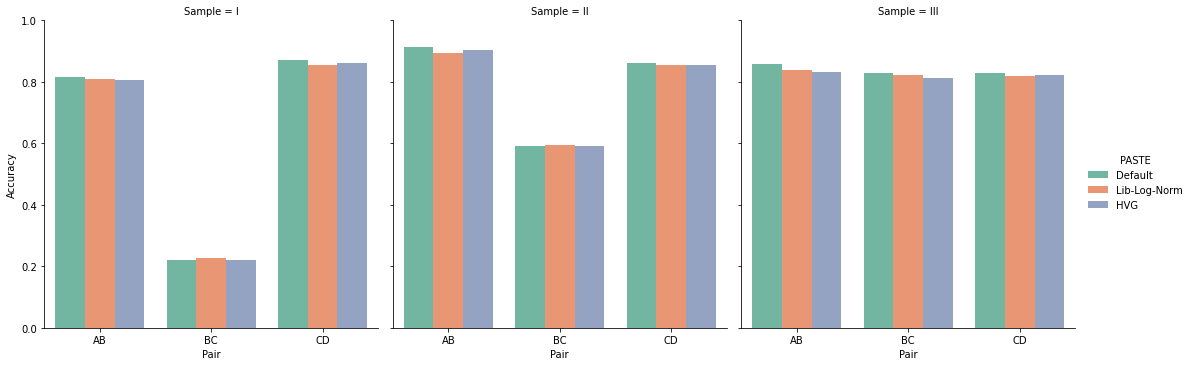

In [4]:
norm_comp_res_df = pd.read_csv('../data/DLPFC/saved_results/PASTE_pairwise_accuracy_gene_similarity.csv',index_col=0,sep=',')
res_df = pd.read_csv('../data/DLPFC/saved_results/PASTE_pairwise_accuracy_results_objective.csv',index_col=0,sep=',').drop('Objective',axis=1)
sample_map,pair_map = {0:'I',1:'II',2:'III'},{0:'AB',1:'BC',2:'CD'}
norm_comp_res_df2 = norm_comp_res_df[norm_comp_res_df['init']==True].copy()
norm_comp_res_df2 = norm_comp_res_df2.append(res_df[((res_df['kind']=='PASTE')&(res_df['alpha']==0.1)&(res_df['init']==True))])
norm_comp_res_df2['sample'] = norm_comp_res_df2['sample'].map(sample_map)
norm_comp_res_df2['pair'] = norm_comp_res_df2['pair'].map(pair_map)
norm_comp_res_df2 = norm_comp_res_df2.rename(columns={'sample':'Sample','pair':'Pair','accuracy':'Accuracy','kind':'PASTE'})
norm_comp_res_df2['PASTE'] = norm_comp_res_df2['PASTE'].map({'PASTE-norm-genes':'Lib-Log-Norm','PASTE-hv-genes':'HVG','PASTE':'Default'})
g = sns.catplot(x="Pair", y="Accuracy", hue='PASTE', col="Sample",data=norm_comp_res_df2,kind="bar", ci=None, aspect=1,legend=True,hue_order=['Default','Lib-Log-Norm','HVG'],palette='Set2')
g.set_axis_labels("Pair", "Accuracy").set(ylim=(0, 1))
print(norm_comp_res_df2.loc[norm_comp_res_df2.groupby(['Sample','Pair']).Accuracy.idxmax()])